# Optimization project: clustering

### We import relevant packages

In [67]:
import time
tic = time.time()

In [68]:
import numpy as np
from numpy import random
import pandas as pd
from sklearn.neighbors import DistanceMetric
import functools
import operator
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import math

# Minimum Spanning Tree Clustering


### Computing all the distances

In [69]:
def compute_dist(df):
    size = len(df)
    result = []
    arr = df.values
    for i in range(size):
        for j in range(i+1,size):
            # We use the package "distance" to compute the euclidean distance between
            # the different points in the dataset
            result.append([i, j, math.sqrt(sum((arr[i] - arr[j])**2))])

    ordered_result = sorted(result, key=lambda t: t[::-1])
    return ordered_result

To find the minimum spanning tree it makes sense to differentiate the following cases:

    case 1: None of them are in a cluster:
    case 2: Only one of them is already in a cluster:
    case 3: Both of them are already in a cluster:
        --> 3a: Both of them are in the same cluster: do nothing
        --> 3b: They are in different clusters: merge the 2 corresponding clusters


In [70]:
def MST_clustering(K, N, ordered_result):
    # We initialize the variables that we will need in the outter for loop
    cluster_dict = {}
    k = 0
    vertex = []
    counter = 0
    i = 0
    final_number_clusters = N-K
    for ite in ordered_result:
        
        # Here we set the condition to include as clusters the points that are left alone in the algorithm. 
        # At this point we will iterate through the rest of edges and we will add the points which have not been
        # visited before (if they have been visited, they already are in one component of the MST)
        
        if counter == final_number_clusters:
            for i in range(N):
                if i not in vertex:
                    k += 1
                    cluster_dict[k] = [i]
                    vertex.append(i)
            return cluster_dict
        # Here we want to know whether the vertices of the edge of this iteartion have already been included in any
        # of the components of the MST. We assign a key to these two vertices. We assign key = -1 to the vertices 
        # that have not been visited before, and if the vertex have already been assigned to a cluster then we assign
        # to him its component/cluster, so key = cluster.
        
        key_0 = -1
        key_1 = -1
        
        if ite[0] not in vertex:
            pass
        else:
            for cluster in cluster_dict:
                if ite[0] in cluster_dict[cluster]:
                    key_0 = cluster
                    
        if ite[1] not in vertex:
            pass
        else:
            for cluster in cluster_dict:
                if ite[1] in cluster_dict[cluster]:
                    key_1 = cluster

                    
        # Now, we have four different cases. (a) None of the vertices have been added to a cluster, (b) one of the
        # vertices has been added to a cluster, (c) both of them have been added to the same cluster (so we will not
        # do anything given that we would be creating a cycle) and (d) both of them have been added to a cluster, but
        # each of them is in a different cluster.
        
        # case (a)
        
        if (key_0 == -1) and (key_1 == -1):
            k += 1
            cluster_dict[k] = [ite[0]] 
            cluster_dict[k] += [ite[1]]
            counter +=1
            vertex.append(ite[0])
            vertex.append(ite[1])
            
        # case (b)
        
        elif (key_0 == -1) and (key_1 != -1):
            cluster_dict[key_1] += [ite[0]]
            counter +=1
            vertex.append(ite[0])
        elif (key_0 != -1) and (key_1 == -1):
            cluster_dict[key_0] += [ite[1]]
            counter +=1
            vertex.append(ite[1])
            
        # case (c) and (d)
        else:
            
            # case (c)
            if key_0 == key_1:
                pass
            
            # case (d)
            else:
                cluster_dict[key_0] += cluster_dict[key_1]
                del cluster_dict[key_1]
                counter +=1
        i +=1
    return cluster_dict

In [71]:
def get_df(cluster_dict):
    ind_list = []
    clust_list = []

    for k, v in cluster_dict.items():
        [clust_list.append(k) for i in v]
        [ind_list.append(val) for val in v]

    df_s = pd.DataFrame()
    df_s['index'] = ind_list
    df_s['Cluster'] = clust_list
    
    df_s = df_s.sort_values('index').set_index('index')
    return df_s

# Davies Bouldin algorithm

In [72]:
def Davies_Bouldin(cluster_dict, df):
    
    # We compute the index of the clusters 
    
    clusters = []
    for n in cluster_dict:
        clusters.append(n)
        
    # We compute the coordinates of the centroid for each cluster
    
    centroid_dict = {}
    for n in clusters:
        mask = (df.Cluster == n)
        cluster_df = df[mask]
        centroid = cluster_df.mean()
        centroid = centroid.to_list()
        list_ = []
        for el in range(0,len(list(df.columns[:-1]))):
            list_.append(centroid[el])
            centroid_dict[n] = list_
            
    # We compute the measure of the scatter within the cluster, S_i
    
    S_i = {}
    for n in cluster_dict:
        sum_ = 0
        for el in cluster_dict[n]:
            sum_ += distance.euclidean(df.iloc[el][:-1],centroid_dict[n])
            average = sum_/len(cluster_dict[n])
            S_i[n] = average
            
    # Compute the distance between the clusters, i.e., the distance between the centroids of the clusters
    
    M_ij = {}
    centroids = list(centroid_dict.keys())
    for i in range(0,len(centroids)):
        for j in range(i+1,len(centroids)):
            d = distance.euclidean(centroid_dict[centroids[i]],centroid_dict[centroids[j]])
            M_ij[(centroids[i],centroids[j])] = d
    
    # We compute D_i by computig in a forloop R_ij
    
    dispersion = list(S_i.keys())
    D_i = {}
    for i in range(0, len(dispersion)):
        D_i[dispersion[i]] = 0
        for j in range(0,len(dispersion)):
            if i!=j:
                try:
                    R_ij = (S_i[dispersion[i]]+S_i[dispersion[j]])/(M_ij[(dispersion[i],dispersion[j])])
                    if R_ij >= D_i[dispersion[i]]:
                        D_i[dispersion[i]] = R_ij
                except:
                    R_ij = (S_i[dispersion[i]]+S_i[dispersion[j]])/(M_ij[(dispersion[j],dispersion[i])])
                    if R_ij >= D_i[dispersion[i]]:
                        D_i[dispersion[i]] = R_ij
                        
    count = 0
    for n in D_i:
        count += D_i[n]
    DB = count/len(D_i)
    return DB

# The Dunn Index

In [73]:
def max_within(ordered_result, cluster_dict):
    for i in range(len(ordered_result)):
        for k,v in cluster_dict.items():
            if ordered_result[-i-1][0] in v and ordered_result[-i-1][1] in v:
                return ordered_result[-i-1][2]

def min_between(ordered_result, cluster_dict):
    for i in range(len(ordered_result)):
        for k,v in cluster_dict.items():
            if ordered_result[i][0] in v and ordered_result[i][1] not in v:
                return ordered_result[i][2]

def dunn(ordered_result, cluster_dict):
    num = max_within(ordered_result, cluster_dict)
    den = min_between(ordered_result, cluster_dict)
    return num/den

# Running the pipeline:

### For the dataset with 2 columns ('Synthetic')

In [74]:
df_synthetic = pd.read_csv('synthetic_clean.csv')
N = len(df_synthetic)

In [75]:
%%time
ordered_result = compute_dist(df_synthetic)

CPU times: user 2min 19s, sys: 5.79 s, total: 2min 25s
Wall time: 2min 30s


In [76]:
#ordered_result_csv = pd.DataFrame(ordered_result)
#ordered_result_csv.to_csv('ordered_result_csv', index=False)

In [77]:
def main_MST(K, df_synthetic):
    #tic1 = time.time()
    cluster_dict = MST_clustering(K, N, ordered_result)
    #tic2 = time.time()
    #print(tic2 - tic1)
    df_synthetic['Cluster']= get_df(cluster_dict)['Cluster']
    #tic3 = time.time()    
    #print(tic3 - tic2)
    DB_MST = Davies_Bouldin(cluster_dict,df_synthetic)
    #tic4 = time.time()
    #print(tic4 - tic3)
    Dunn_MST = dunn(ordered_result, cluster_dict)
    #tic5 = time.time()    
    #print(tic5 - tic4)
    #package_MST = davies_bouldin_score(df.drop('Cluster',axis=1), labels = df['Cluster'].to_list())
    
    return DB_MST, Dunn_MST

In [78]:
len(ordered_result)

12497500

In [79]:
%%time 
DB, Dunn = main_MST(15, df_synthetic)

CPU times: user 7min 47s, sys: 2.9 s, total: 7min 50s
Wall time: 8min 3s


### For the dataset with 5 columns ('Thyroid')

In [80]:
df_thyroid = pd.read_csv('thyroid_clean.csv')
N = len(df_thyroid)

In [81]:
%%time
ordered_result = compute_dist(df_thyroid)

CPU times: user 7.42 s, sys: 2.43 s, total: 9.85 s
Wall time: 10 s


In [82]:
%%time
n_clusters = []
DB_MST = []
Dunn_MST = []
for K in range(2, N+1, 10):
    n_clusters.append(K)
    DB, Dunn = main_MST(K, df_thyroid)
    DB_MST.append(DB)
    Dunn_MST.append(Dunn)

CPU times: user 14.2 s, sys: 50.4 ms, total: 14.2 s
Wall time: 14.3 s


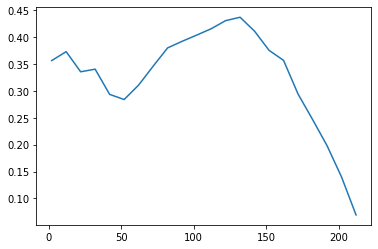

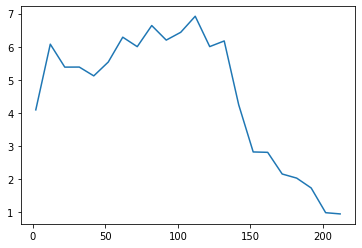

In [83]:
import seaborn as sns
sns.lineplot(n_clusters,DB_MST)
plt.show()
sns.lineplot(n_clusters,Dunn_MST)
plt.show()

## K-Means Clustering

In [84]:
# Randomly assign indeces of cluster centroids:
def initiate_centroids(k, df):
    centroids = []
    random.seed(42) #for reproducability  
    #generate random centroid indeces
    initial_index_centroid = random.sample(range(0, len(df)), k)
    #find the data points corresponding the the indeces:
    for i in initial_index_centroid:
        centroids.append(df.loc[i])
    return np.array(centroids)

# To find the closest centroid to each data point:
def findClosestCentroids(centroids, df):
    assigned_centroid = []
    arr = df.to_numpy()
    #iterate over every data point in the dataframe:
    for row in arr:
        distance=[]
        #find distance of data point with each cluster:
        for center in centroids:          
            distance.append(np.linalg.norm(row-center))     
        #assign data point to closest cluster:
        assigned_centroid.append(np.argmin(distance))
    return assigned_centroid


#To update the centroid of the clusters:
def calc_centroids(clusters, df): 
    #initiate empty list for new centroids of each cluster:
    new_centroids = []
    #df including each point and its respective cluster 
    arr = np.c_[df.to_numpy(), clusters]
    #iterate over the distinct clusters
    for c in np.unique(clusters):    
        #take out the data points corresponding to each cluster:
        current_arr = arr[arr[:, -1] == c][:,:-1]   
        #find the new cluster centroid which is the mean of the clusters we already assigned
        cluster_mean = current_arr.mean(axis=0)                                          
        #append the new centroid
        new_centroids.append(cluster_mean)   
    return np.vstack(new_centroids)

#Recursively find and update cluster centroids:
#n: number of clusters, df: dataframe of data points

In [85]:
def KMeans_Clustering(k, df):
    #initiate centroids:
    old_centroids = initiate_centroids(k, df)
    #initiate new centroids (do this for first while loop condition to work)
    new_centroids = calc_centroids(findClosestCentroids(old_centroids, df), df)
    # Iterate until the absoulte difference between the coordinates of all centroids 
    #does not change, ie: the k-means algorithm converges:
    while np.absolute(np.array(new_centroids) - np.array(old_centroids)).all() > 0.0005:
        #set new centroids as the old ones:
        old_centroids = new_centroids
        #find the new ones:
        new_centroids = calc_centroids(findClosestCentroids(old_centroids, df), df)
        #print(np.array(new_centroids))
    return findClosestCentroids(new_centroids, df)

In [86]:
def get_cluster_dict_2(df):
    cluster_dict = {}
    visited = []
    for n in range(0,len(df)):
        if int(df.iloc[n][2]) in visited:
            cluster_dict[int(df.iloc[n][2])] += [n]
        else:
            cluster_dict[int(df.iloc[n][2])] = [n]
            visited.append(int(df.iloc[n][2]))
    return cluster_dict

In [87]:
def get_cluster_dict_5(df):
    cluster_dict = {}
    visited = []
    for n in range(0,len(df)):
        if int(df.iloc[n][5]) in visited:
            cluster_dict[int(df.iloc[n][5])] += [n]
        else:
            cluster_dict[int(df.iloc[n][5])] = [n]
            visited.append(int(df.iloc[n][5]))
    return cluster_dict

# Running the pipeline:

### For the dataset with 2 columns ('Synthetic')

In [88]:
#N = 200
#X1, X2 = simulate_data_2(N)
#df = pd.DataFrame({'X1': X1, 'X2': X2}, columns=['X1', 'X2'])
df = pd.read_csv('synthetic_clean.csv')

def main_KMeans(k, df):
    
    df['Cluster'] = KMeans_Clustering(k, df_synthetic)
    cluster_dict = get_cluster_dict_2(df_synthetic)
    DB_KMeans = Davies_Bouldin(cluster_dict, df_synthetic)
    Dunn_KMeans = dunn(ordered_result, cluster_dict)
    
    return DB_KMeans, Dunn_KMeans

In [89]:
DB_KMeans, Dunn_KMeans = main_KMeans(15, df_synthetic)

In [90]:
DB_KMeans

0.8112632423474295

In [91]:
Dunn_KMeans

95.63292584662405

### For the dataset with 5 columns ('Thyroid')

In [92]:
df = pd.read_csv('thyroid_clean.csv')
N = len(df_thyroid)
ordered_result = compute_dist(df_thyroid)

In [93]:
def main_KMeans(k, df):
    
    df['Cluster'] = KMeans_Clustering(k, df_thyroid)
    cluster_dict = get_cluster_dict_5(df_thyroid)
    DB_KMeans = Davies_Bouldin(cluster_dict, df_thyroid)
    Dunn_KMeans = dunn(ordered_result, cluster_dict)
    #package_MST = davies_bouldin_score(df.drop('Cluster',axis=1), labels = df['Cluster'].to_list())

    
    return DB_KMeans, Dunn_KMeans

In [94]:
%%time
n_clusters = []
DB_KMeans = []
Dunn_KMeans = []
for K in range(2, N+1, 10):
    n_clusters.append(K)
    DB, Dunn = main_KMeans(K, df_thyroid)
    DB_KMeans.append(DB)
    Dunn_KMeans.append(Dunn)

CPU times: user 23.9 s, sys: 174 ms, total: 24.1 s
Wall time: 25.6 s


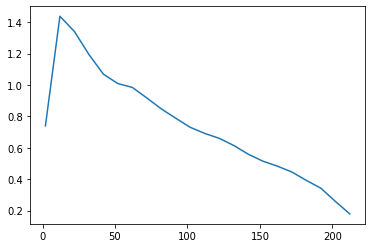

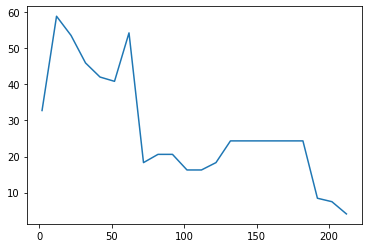

In [95]:
import seaborn as sns
sns.lineplot(n_clusters, DB_KMeans)
plt.show()
sns.lineplot(n_clusters, Dunn_KMeans)
plt.show()

In [96]:
toc = time.time()
toc-tic

697.7027230262756

In [97]:
(toc-tic)/60

11.628378717104594